In [81]:
!pip install --upgrade tensorflow_hub

     |████████████████████████████████| 108 kB 2.4 MB/s eta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense, Conv2D, MaxPool2D, Input, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score, confusion_matrix

import os
from zipfile import ZipFile


import mlflow
import mlflow.keras
from urllib.parse import urlparse

%matplotlib inline
tf.__version__

'2.4.1'

In [2]:
!ls

copy_dataset.sh  exp_fungo_videira.ipynb  material_apoio  __pycache__
exemplos_net	 imagens		  mlruns


# Copy images to dataset directory

In [51]:
!chmod +x copy_dataset.sh
!./copy_dataset.sh

In [27]:
tf.random.set_seed(42)

# Create DataFrame from Dir

In [28]:
path_dataset_negativo= './imagens/doenca_fungica_videira/negativo'
dataset_negativo = os.listdir(path_dataset_negativo)
     
dataset_df_neg = pd.DataFrame({'file_names': dataset_negativo, 'labels': ['negativo']*len(dataset_negativo)})
print('{}\n'.format(dataset_df_neg.head(3)))

path_dataset_positivo= './imagens/doenca_fungica_videira/positivo'
dataset_positivo = os.listdir(path_dataset_positivo)
     
dataset_df_pos = pd.DataFrame({'file_names': dataset_positivo, 'labels': ['positivo']*len(dataset_positivo)})
print('Pos dataset shape: {}\n '.format(dataset_df_pos.shape))

dataset_df = pd.concat([dataset_df_pos,dataset_df_neg],axis=0)
print('Final dataset shape: {}'.format(dataset_df.shape))

  file_names    labels
0  109_n.png  negativo
1  128_n.png  negativo
2  167_n.png  negativo

Pos dataset shape: (77, 2)
 
Final dataset shape: (158, 2)


# Split Train and Test DataSet

In [29]:
X_train, X_test, y_train, y_test= train_test_split(dataset_df['file_names'],dataset_df['labels'],test_size=0.2,shuffle=True)

# Create DataFrame for Train and Test Dataset

In [30]:
train_df = pd.concat([X_train,y_train],axis=1)
print ('train dataset \n{}'.format(train_df['labels'].value_counts()))

test_df = pd.concat([X_test,y_test],axis=1)
print('test dataset \n{}'.format(test_df['labels'].value_counts()))

train dataset 
negativo    66
positivo    60
Name: labels, dtype: int64
test dataset 
positivo    17
negativo    15
Name: labels, dtype: int64


# Data Image Generator from DataFrame

In [31]:
path_dataset= './imagens/doenca_fungica_videira/dataset'
datagen_train=ImageDataGenerator(rescale=1./255,
                           rotation_range=0.2,                 
                           width_shift_range=0.2,            
                           height_shift_range=0.2,
                           zoom_range=0.2,
                           horizontal_flip=True)

print ("Train DataSet Generator")
train_data = datagen_train.flow_from_dataframe(dataframe=train_df, target_size=(32,32),batch_size=8,directory=path_dataset, x_col="file_names",y_col="labels", class_mode="binary",seed=42)


X,y=train_data.next() # X[photo x size_y x size_x x RBG] e y[photo x binary_class_2_bits]
print ("dataset feature shape: " + str(X.shape))
print ("dataset target shape: " + str(y.shape))


labels = list(train_data.class_indices.keys())
print('labels {}\n'.format(labels))

print ("Test DataSet Generator")
datagen_test=ImageDataGenerator(rescale=1./255)
test_data =datagen_test.flow_from_dataframe(dataframe=test_df, target_size=(32,32),batch_size=8,directory=path_dataset, x_col="file_names",y_col="labels", class_mode="binary",seed=42)

Train DataSet Generator
Found 126 validated image filenames belonging to 2 classes.
dataset feature shape: (8, 32, 32, 3)
dataset target shape: (8,)
labels ['negativo', 'positivo']

Test DataSet Generator
Found 32 validated image filenames belonging to 2 classes.


# Creating Model 1 - Without transfer Learning

## Create mlflow experiment

In [ ]:
idExperiment = mlflow.create_experiment('CNN without Transfer Learning')

In [77]:
experiment=mlflow.get_experiment_by_name('CNN without Transfer Learning')
idExperiment=experiment.experiment_id
idExperiment

'0'

## Hyperparameters

In [32]:
lr_1 = 0.00001
epochs_1 = 130

## Sequential, compile and fit

Epoch 1/130
16/16 - 5s - loss: 0.6930 - acc: 0.5317 - val_loss: 0.6935 - val_acc: 0.4688
Epoch 2/130
16/16 - 2s - loss: 0.6931 - acc: 0.5635 - val_loss: 0.6934 - val_acc: 0.4688
Epoch 3/130
16/16 - 2s - loss: 0.6930 - acc: 0.5476 - val_loss: 0.6935 - val_acc: 0.4688
Epoch 4/130
16/16 - 2s - loss: 0.6927 - acc: 0.5238 - val_loss: 0.6935 - val_acc: 0.4688
Epoch 5/130
16/16 - 2s - loss: 0.6928 - acc: 0.5079 - val_loss: 0.6934 - val_acc: 0.4688
Epoch 6/130
16/16 - 2s - loss: 0.6927 - acc: 0.5873 - val_loss: 0.6933 - val_acc: 0.4688
Epoch 7/130
16/16 - 2s - loss: 0.6924 - acc: 0.5873 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 8/130
16/16 - 2s - loss: 0.6925 - acc: 0.5317 - val_loss: 0.6932 - val_acc: 0.4688
Epoch 9/130
16/16 - 3s - loss: 0.6931 - acc: 0.5238 - val_loss: 0.6931 - val_acc: 0.4688
Epoch 10/130
16/16 - 3s - loss: 0.6928 - acc: 0.5556 - val_loss: 0.6931 - val_acc: 0.4688
Epoch 11/130
16/16 - 2s - loss: 0.6921 - acc: 0.5635 - val_loss: 0.6929 - val_acc: 0.4688
Epoch 12/130
16/16 

<AxesSubplot:>

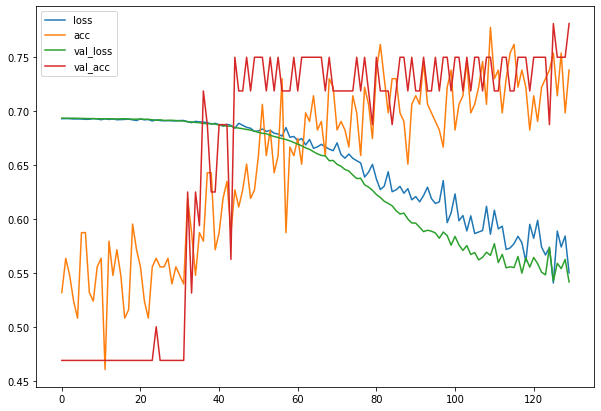

In [34]:
model_1=tf.keras.models.Sequential([
               Input(X.shape[1:]),
               Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
               MaxPool2D(2,2),
               Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
               MaxPool2D(2,2),
               Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
               MaxPool2D(2,2),
               Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"),
               MaxPool2D(2,2),
               Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
               MaxPool2D(2,2),
               Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
               Flatten(),
               Dense(units=64, activation='relu'),
               Dropout(0.4),
               Dense(units=16, activation='relu'),
               Dense(1,activation='sigmoid')
        ])

model_1.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=lr_1), metrics=["acc"])

history_1 = model_1.fit(train_data,
                        epochs=epochs_1,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),verbose=2)



history_1_df = pd.DataFrame(history_1.history)
history_1_df.to_csv('temp/history_{}.txt'.format(idExperiment))
history_1_df.plot(figsize=(10, 7))

## Metrics

In [35]:
def preprocess_image(image_path,size):
    img = keras.preprocessing.image.load_img(image_path, target_size=(size, size))
    img = keras.preprocessing.image.img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    return tf.convert_to_tensor(img)

def test_samples(model):
    for class_val in ['neg','pos']:
        for seq in range(1,4):
            img = preprocess_image("exemplos_net/{}_{}.png".format(class_val,seq),32)
            if class_val=='neg':
                print('Negative values - Prediction: ' + labels[int(np.round(model.predict(img)))])
            else:
                print('Positive values - Prediction: ' + labels[int(np.round(model.predict(img)))])

def get_test_y_pred(model,test_gen):

    test_x =[]
    test_y =[]
    for i in range(0,len(test_data)):
        test_x.extend(np.array(test_data[i][0]))
        test_y.extend(np.array(test_data[i][1]))
    test_x=np.array(test_x)
    test_y=np.array(test_y)
    
    pred = np.round(model.predict(test_x))
    pred = pred.ravel()
    return test_y,pred

In [80]:
test_samples(model_1)

Negative values - Prediction: negativo
Negative values - Prediction: negativo
Negative values - Prediction: negativo
Positive values - Prediction: positivo
Positive values - Prediction: positivo
Positive values - Prediction: positivo


In [81]:
test_y, test_pred_1 =  get_test_y_pred(model_1,test_data)
print(test_y)
print(test_pred_1)

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 0.]
[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 0. 0. 0.]


Text(0.5, 15.0, 'Predicted')

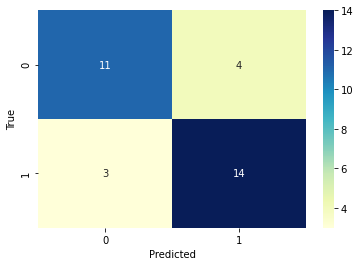

In [82]:
sn.heatmap(confusion_matrix(test_y,test_pred_1),annot=True,cmap="YlGnBu")
plt.ylabel('True')
plt.xlabel('Predicted')

In [83]:
f1_score(test_y,test_pred_1)

0.7999999999999999

In [16]:
#keras.models.save_model(model_1,'./models/model_1')
#model_1=keras.models.load_model('modelos/without')

## Log Mlflow

In [72]:
def log_experiment(id_exp,lr,epochs,model,history,test_y,test_pred):
    with mlflow.start_run(experiment_id=id_exp):

        mlflow.log_param("lr", lr)
        mlflow.log_param("ephocs", epochs)

        mlflow.log_metric("loss", history.history['loss'][-1])
        mlflow.log_metric("acc", history.history['acc'][-1])
        mlflow.log_metric("f1_score", f1_score(test_y,test_pred))
        
        mlflow.log_artifact("temp/history_{}.txt".format(id_exp), artifact_path="logs")
        
        
        summary=pd.DataFrame(columns=["Name","Type","Shape"])
        for layer in model_1.layers:
            summary = summary.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape}, ignore_index=True)
        summary.to_csv('temp/summary_{}.txt'.format(id_exp))
        mlflow.log_artifact('temp/summary_{}.txt'.format(id_exp), artifact_path="summary")

        mlflow.keras.log_model(model_1,'model')

In [84]:
log_experiment(idExperiment,lr_1,epochs_1,model_1,history_1, test_y,test_pred_1)

INFO:tensorflow:Assets written to: /tmp/tmphorco0h1/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmphorco0h1/model/data/model/assets


# Creating Model 2 - With transfer Learning

## Create mlflow experiment

In [ ]:
idExperiment = mlflow.create_experiment('CNN with Transfer Learning')

## Hyperparameters

In [46]:
lr_2 = 0.0001
epochs_2 = 50
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [75]:
experiment=mlflow.get_experiment_by_name('CNN with Transfer Learning')
idExperiment=experiment.experiment_id
idExperiment

'1'

In [47]:
def create_model(model_url,image_shape):
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=image_shape) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/50
16/16 - 21s - loss: 0.6917 - acc: 0.5397 - val_loss: 0.6795 - val_acc: 0.8125
Epoch 2/50
16/16 - 4s - loss: 0.6742 - acc: 0.6667 - val_loss: 0.6779 - val_acc: 0.6875
Epoch 3/50
16/16 - 4s - loss: 0.6675 - acc: 0.6587 - val_loss: 0.6722 - val_acc: 0.5938
Epoch 4/50
16/16 - 3s - loss: 0.6525 - acc: 0.7063 - val_loss: 0.6629 - val_acc: 0.7500
Epoch 5/50
16/16 - 4s - loss: 0.6517 - acc: 0.6905 - val_loss: 0.6626 - val_acc: 0.6875
Epoch 6/50
16/16 - 4s - loss: 0.6393 - acc: 0.7063 - val_loss: 0.6524 - val_acc: 0.7500
Epoch 7/50
16/16 - 3s - loss: 0.6268 - acc: 0.7698 - val_loss: 0.6409 - val_acc: 0.6875
Epoch 8/50
16/16 - 4s - loss: 0.6240 - acc: 0.7619 - val_loss: 0.6310 - val_acc: 0.

<AxesSubplot:>

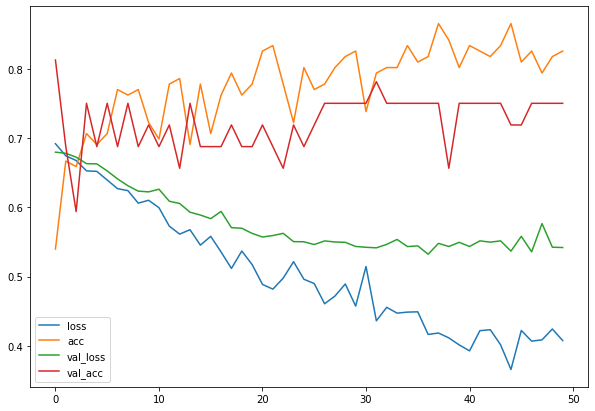

In [48]:
model_2 = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  image_shape=X.shape[1:])

model_2.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(learning_rate=lr_2),
                           metrics=['acc'])

history_2 = model_2.fit(train_data,
                        epochs=epochs_2,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),verbose=2)


history_2_df = pd.DataFrame(history_2.history)
history_2_df.to_csv('temp/history_{}.txt'.format(idExperiment))
history_2_df.plot(figsize=(10, 7))

## Métricas

In [49]:
test_y, test_pred_2 =  get_test_y_pred(model_2,test_data)
print(test_y)
print(test_pred_2)

[1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 0.]
[1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 0.]


Text(0.5, 15.0, 'Predicted')

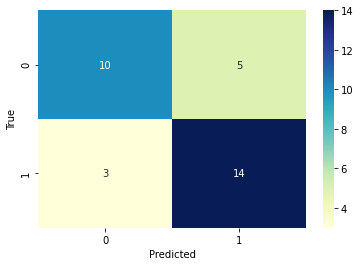

In [50]:
sn.heatmap(confusion_matrix(test_y,test_pred_2),annot=True,cmap="YlGnBu")
plt.ylabel('True')
plt.xlabel('Predicted')

In [51]:
test_samples(model_2)

Negative values - Prediction: negativo
Negative values - Prediction: negativo
Negative values - Prediction: positivo
Positive values - Prediction: positivo
Positive values - Prediction: negativo
Positive values - Prediction: positivo


In [52]:
f1_score(test_y,test_pred_2)

0.7777777777777778

## Log Mlflow

In [76]:
log_experiment(idExperiment,lr_2,epochs_2,model_2,history_2, test_y,test_pred_2)

INFO:tensorflow:Assets written to: /tmp/tmpqvddfpc4/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpqvddfpc4/model/data/model/assets


In [141]:
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

import mlflow
import os 


client = MlflowClient()

experiments = client.list_experiments(view_type=ViewType.ACTIVE_ONLY)
experiments[0].name

'CNN with Transfer Learning'

In [140]:
model_3 = keras.models.load_model('model')